## Setup

In [1]:
import math
from random import randint
import matplotlib.pyplot as plt
import numpy as np
import ipywidgets as widgets
from typing import Tuple, List, Callable, Any

In [2]:
def steep_valley_function():
    def f(x, y):
        # Define a function with a steeper gradient in the y-direction
        return 0.5 * x**2 + 2 * y**2

    def grad(x, y):
        # Compute the gradient of the function
        grad_x = x  # Gradient with respect to x
        grad_y = 4 * y  # Gradient with respect to y, steeper than x
        return np.array([grad_x, grad_y])

    x = np.linspace(-20, 20, 400)
    y = np.linspace(-20, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def l_shaped_valley_function():
    def f(x, y):
        # Creating an L-shaped valley with a sharp turn
        # Define the valley with two different linear regions
        # Horizontal part (x > y), Vertical part (x <= y)
        return np.where(x > y, (y + 20) ** 2 + x, (x + 20) ** 2 + y)

    def grad(x, y):
        # Gradient of the L-shaped function, changing at x = y
        # Horizontal part gradient
        grad_x = np.where(x > y, 1, 2 * (x + 20))
        grad_y = np.where(x > y, 2 * (y + 20), 1)
        return np.array([grad_x, grad_y])

    x = np.linspace(-50, 20, 400)
    y = np.linspace(-50, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def complex_function():
    def f(x, y):
        # Scale the coefficients to increase the depth and curvature differences
        return (
            0.3 * (x - 10) ** 2
            + 0.2 * (y - 10) ** 2
            + 1 * (x + 10) ** 2
            + 1 * (y + 10) ** 2
        )

    def grad(x, y):
        # Adjusted gradient for the scaled function
        grad_x = 0.6 * (x - 10) + 2 * (
            x + 10
        )  # Increased coefficients for the gradients
        grad_y = 0.4 * (y - 10) + 2 * (y + 10)
        return np.array([grad_x, grad_y])

    x = np.linspace(-20, 20, 400)
    y = np.linspace(-20, 20, 400)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad


def simple_function():
    def f(x, y):
        return x**2 + y**2  # Z as a function of X and Y

    def grad(x, y):
        grad_x = 2 * x
        grad_y = 2 * y
        return np.array([grad_x, grad_y])

    x = np.linspace(-20, 20, 100)
    y = np.linspace(-20, 20, 100)
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    return X, Y, Z, f, grad

In [42]:
def build_output():
    lr_slider = widgets.FloatSlider(
        value=0.1,
        min=0,
        max=2,
        step=0.01,
        description="Learning Rate",
        style={"description_width": "initial"},
        layout=widgets.Layout(width="100%"),
    )
    steps_slider = widgets.IntSlider(
        value=10,
        min=1,
        max=30,
        step=1,
        description="Steps",
        style={"description_width": "initial"},
        layout=widgets.Layout(width="100%"),
    )
    func_dropdown = widgets.Dropdown(
        description="Function",
        options=[
            ("Steep Valley Function", steep_valley_function),
            ("simple Function", simple_function),
            ("complex Function", complex_function),
            ("L-shaped Valley Function", l_shaped_valley_function),
        ],
        layout=widgets.Layout(width="100%"),
    )
    x_slider = widgets.IntSlider(
        value=15,
        min=-20,
        max=20,
        step=1,
        description="Starting X",
        layout=widgets.Layout(width="100%"),
    )
    y_slider = widgets.IntSlider(
        value=10,
        min=-20,
        max=20,
        step=1,
        description="Starting Y",
        layout=widgets.Layout(width="100%"),
    )
    beta1_slider = widgets.FloatSlider(
        value=0.9,
        min=0,
        max=1,
        step=0.01,
        description="Beta1 Factor",
        layout=widgets.Layout(width="100%"),
    )
    beta2_slider = widgets.FloatSlider(
        value=0.999,
        min=0,
        max=1,
        step=0.01,
        description="Beta2 Factor",
        layout=widgets.Layout(width="100%"),
    )
    optimizer_multiselect = widgets.SelectMultiple(
        description="Optimizer",
        value=["regular", "momentum"],
        options=["regular", "momentum", "nesterov", "adagrad", "rmsprop", "adam"],
        layout=widgets.Layout(width="100%"),
    )

    ui = widgets.VBox(
        [
            widgets.HBox([x_slider, y_slider]),
            widgets.HBox([lr_slider, steps_slider]),
            widgets.HBox([beta1_slider, beta2_slider]),
            widgets.HBox([func_dropdown, optimizer_multiselect]),
        ]
    )

    def update_plot(optimizers, function, steps, lr, beta1, beta2, initialX, initialY):
        cur_pos = np.array([initialX, initialY])
        results = optimize_multiple(
            optimizers=optimizers,
            function=function,
            steps=steps,
            lr=lr,
            beta1=beta1,
            beta2=beta2,
            cur_pos=cur_pos,
            print_res=False,
        )
        plot_optimization_path(results)

    out = widgets.interactive_output(
        update_plot,
        {
            "optimizers": optimizer_multiselect,
            "function": func_dropdown,
            "steps": steps_slider,
            "lr": lr_slider,
            "beta1": beta1_slider,
            "beta2": beta2_slider,
            "initialX": x_slider,
            "initialY": y_slider,
        },
    )

    display(ui, out)


build_output()

Output()

In [39]:
def optimize(
    # parent method to call all other optimization methods
    optimizer_type="regular",
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    beta2=0.999,
    cur_pos=np.array([15, 18]),
    print_res=False,
) -> Tuple[Callable[[float, float], float], List[np.ndarray], List[float], str]:

    # Choose and run the optimizer
    # they always return this way: X Y Z positions,
    if optimizer_type == "regular":
        return regular_gradient_descent(function, steps, lr, cur_pos, print_res)
    elif optimizer_type == "momentum":
        return momentum_gradient_descent(function, steps, lr, beta1, cur_pos, print_res)
    elif optimizer_type == "nesterov":
        return nesterov_gradient_descent(function, steps, lr, beta1, cur_pos, print_res)
    elif optimizer_type == "adagrad":
        return adagrad_gradient_descent(function, steps, lr, cur_pos, print_res)
    elif optimizer_type == "rmsprop":
        return rmsprop_gradient_descent(function, steps, lr, beta1, cur_pos, print_res)
    elif optimizer_type == "adam":
        return adam_gradient_descent(
            function, steps, lr, beta1, beta2, cur_pos, print_res
        )


def optimize_multiple(
    optimizers=["regular", "momentum"],
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    beta2=0.999,
    cur_pos=np.array([15, 18]),
    print_res=False,
):
    results = []
    for optimizer in optimizers:
        results.append(
            optimize(optimizer, function, steps, lr, beta1, beta2, cur_pos, print_res)
        )
    return results

In [5]:
def plot_optimization_path(optimizer_results):
    fig = plt.figure(figsize=(24, 8))
    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax2 = fig.add_subplot(1, 2, 2)  # 2D plot for top-down heatmap view

    # Assuming all optimizers use the same function landscape
    # Extract the function and compute the landscape (X, Y, Z) based on the first optimizer's function
    f = optimizer_results[0][0]
    x_range = np.linspace(-20, 20, 400)
    y_range = np.linspace(-20, 20, 400)
    X, Y = np.meshgrid(x_range, y_range)
    Z = f(X, Y)

    # Plot the 3D surface
    ax1.plot_surface(X, Y, Z, alpha=0.5, cmap='viridis', edgecolor='none')
    ax1.set_title('3D View - Optimization Paths')

    # Plot the 2D heatmap
    ax2.contourf(X, Y, Z, levels=100, cmap='viridis')
    ax2.set_title('Top-Down View (2D) - Optimization Paths')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')

    # Define a color palette
    colors = ['red', 'blue', 'green', 'orange', 'purple']  # Extend as needed

    # Plot the paths for each optimizer
    for idx, (f, positions, z_values, name) in enumerate(optimizer_results):
        positions_array = np.array(positions)
        
        # 3D Path
        ax1.scatter(
            positions_array[:, 0], positions_array[:, 1], z_values,
            color=colors[idx % len(colors)], s=50, label=name
        )
        
        # 2D Path
        ax2.plot(
            positions_array[:, 0],
            positions_array[:, 1],
            marker='o',
            color=colors[idx % len(colors)],
            markersize=5,
            linestyle='--',
            linewidth=2,
            label=name
        )

    ax1.legend()  # Show legends to label different optimizer paths
    ax2.legend()

    plt.show()

## Different Gradient Descents

$$
\theta \leftarrow \theta - \eta \nabla_{\theta} J(\theta)
$$

In [43]:
def regular_gradient_step(pos, lr, grad):
    return pos - lr * grad(*pos)


def regular_gradient_descent(
    function=steep_valley_function,
    steps=1,
    lr=0.1,
    cur_pos=np.array([15, 18]),
    print_res=False,
) -> Tuple[Callable[[float, float], float], List[np.ndarray], List[float], str]:
    X, Y, Z, f, grad = function()
    positions = [cur_pos]
    z_values = [f(cur_pos[0], cur_pos[1])]

    for i in range(steps):
        cur_pos = regular_gradient_step(cur_pos, lr, grad)
        positions.append(cur_pos)
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X, Y = {cur_pos}, Z = {cur_z}")

    return (f, positions, z_values, "Regular Gradient Descent")


def momentum_step(pos, lr, beta, momentum, grad):
    gradient = grad(*pos)
    momentum = beta * momentum - lr * gradient
    pos = pos + momentum

    return momentum, pos


def momentum_gradient_descent(
    function=steep_valley_function,
    steps=1,
    lr=0.1,
    beta1=0.9,
    cur_pos=np.array([15, 18]),
    print_res=False,
):
    X, Y, Z, f, grad = function()
    momentum = np.zeros(2)
    positions = [cur_pos]
    z_values = [f(cur_pos[0], cur_pos[1])]

    for i in range(steps):
        momentum, cur_pos = momentum_step(cur_pos, lr, beta1, momentum, grad)
        positions.append(cur_pos)
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X, Y = {cur_pos}, Z = {cur_z}")

    return (f, positions, z_values, "Momentum Gradient Descent")


def nesterov_step(pos, lr, beta, momentum, grad):
    lookahead_pos = (
        pos + beta * momentum
    )  # Use the gradient slightly ahead in the direction of the momentum
    gradient = grad(*lookahead_pos)
    momentum = beta * momentum - lr * gradient
    pos = pos + momentum

    return momentum, pos


def nesterov_gradient_descent(
    function=steep_valley_function,
    steps=1,
    lr=0.1,
    beta1=0.9,
    cur_pos=np.array([15, 18]),
    print_res=False,
):
    X, Y, Z, f, grad = function()
    momentum = np.zeros(2)  # Initial momentum vector
    positions = [cur_pos]
    z_values = [f(cur_pos[0], cur_pos[1])]

    for i in range(steps):
        momentum, cur_pos = nesterov_step(cur_pos, lr, beta1, momentum, grad)
        positions.append(cur_pos.copy())  # Append the new position after update
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X, Y = {cur_pos}, Z = {cur_z}")

    # Use the generic plotting function to visualize the path
    return (f, positions, z_values, "Nesterov Gradient Descent")


def adagrad_step(pos, lr, grad, s):
    epsilon = 10 ** (-10)  # set to different value if needed
    gradient = grad(*pos)
    s += gradient**2  # Accumulate squared gradients
    adjusted_lr = lr / (np.sqrt(s) + epsilon)
    pos = pos - adjusted_lr * gradient
    return pos, s


def adagrad_gradient_descent(
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    cur_pos=np.array([15, 18]),
    print_res=False,
):
    X, Y, Z, f, grad = function()
    positions = [cur_pos.copy()]
    z_values = [f(cur_pos[0], cur_pos[1])]

    s = np.zeros(2)  # Initialize sum of squares of gradients

    for i in range(steps):
        cur_pos, s = adagrad_step(cur_pos, lr, grad, s)
        positions.append(cur_pos.copy())  # Ensure a deep copy for immutability in list
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    return (f, positions, z_values, "AdaGrad Gradient Descent")


def rmsprop_step(pos, lr, grad, s, beta=0.9, epsilon=1e-8):
    gradient = grad(*pos)
    s = beta * s + (1 - beta) * gradient * gradient
    pos = pos - (lr * gradient / (np.sqrt(s + epsilon)))
    return pos, s

    # # alternative function with adjusted learning rate
    # gradient = grad(*pos)
    # s = beta * s + (1 - beta) * gradient ** 2  # Update accumulation of squared gradients
    # adjusted_lr = lr / (np.sqrt(s) + epsilon)  # Adjust learning rate
    # pos = pos - adjusted_lr * gradient  # Update position
    # return pos, s


def rmsprop_gradient_descent(
    function=steep_valley_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    cur_pos=np.array([15, 18]),
    print_res=False,
):
    X, Y, Z, f, grad = function()
    positions = [cur_pos.copy()]
    z_values = [f(cur_pos[0], cur_pos[1])]

    s = np.zeros_like(cur_pos)  # Initialize the RMS accumulation variable
    for i in range(steps):
        cur_pos, s = rmsprop_step(
            cur_pos, lr, grad, s, beta1
        )  # Update position and RMS
        positions.append(cur_pos.copy())  # Ensure a deep copy for immutability in list
        cur_z = f(cur_pos[0], cur_pos[1])
        z_values.append(cur_z)
        if print_res:
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    return (f, positions, z_values, "AdaGrad Gradient Descent")

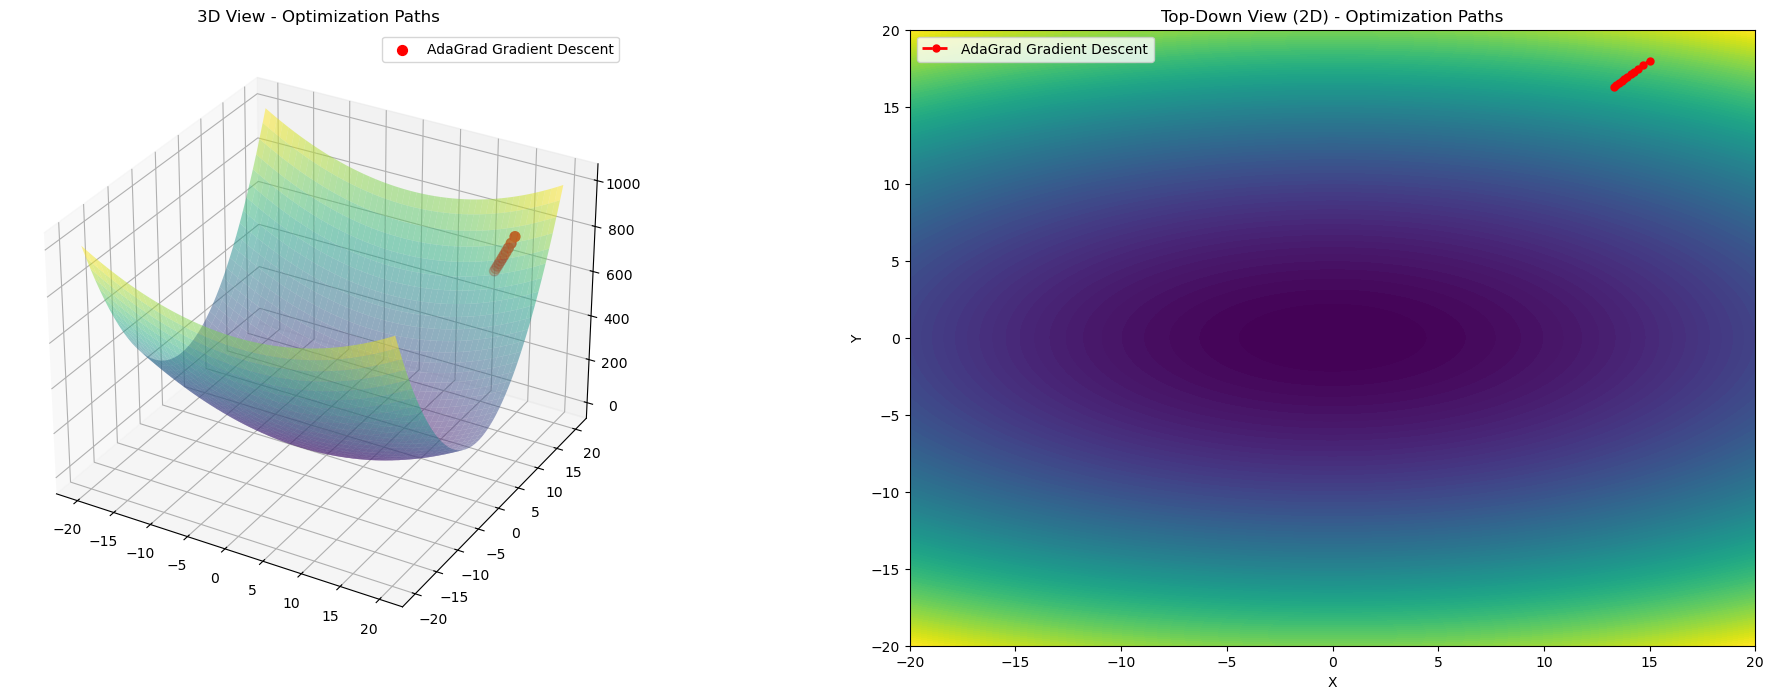

In [46]:
# results = optimize_multiple(optimizers=["adagrad"])
results = optimize("rmsprop")
plot_optimization_path([results])

## Adam

$$ \mathbf{m} \leftarrow \beta_1 \mathbf{m} + (1 - \beta_1) \nabla_{\theta} J(\theta) $$
$$ \mathbf{s} \leftarrow \beta_2 \mathbf{s} + (1 - \beta_2) \nabla_{\theta} J(\theta) \otimes \nabla_{\theta} J(\theta) $$
$$ \widehat{\mathbf{m}} \leftarrow \frac{\mathbf{m}}{1 - \beta_1^t}, \quad \widehat{\mathbf{s}} \leftarrow \frac{\mathbf{s}}{1 - \beta_2^t} $$
$$ \theta \leftarrow \theta - \eta \widehat{\mathbf{m}} \oslash \sqrt{\widehat{\mathbf{s}} + \epsilon} $$

In [ ]:
def adam_step(pos, lr, grad, m, v, t, beta1=0.9, beta2=0.999, epsilon=1e-8):
    gradient = grad(*pos)
    m = beta1 * m + (1 - beta1) * gradient  # Update biased first moment estimate
    v = beta2 * v + (1 - beta2) * gradient**2  # Update biased second moment estimate
    m_hat = m / (1 - beta1**t)  # Compute bias-corrected first moment estimate
    v_hat = v / (1 - beta2**t)  # Compute bias-corrected second moment estimate
    pos = pos - lr * m_hat / (np.sqrt(v_hat) + epsilon)  # Update parameters
    return pos, m, v


def adam_gradient_descent(
    function=simple_function,
    steps=10,
    lr=0.1,
    beta1=0.9,
    beta2=0.999,
    print_res=False,
    initialRandom=True,
    initialX=10,
    initialY=10,
):
    X, Y, Z, f, grad = function()
    if initialRandom:
        cur_pos = np.array([np.random.randint(-20, 20), np.random.randint(-20, 20)])
    else:
        cur_pos = np.array([initialX, initialY])

    m = np.zeros_like(cur_pos)  # Initialize first moment vector
    v = np.zeros_like(cur_pos)  # Initialize second moment vector
    t = 0  # Initialize timestep

    positions = [cur_pos.copy()]  # Store positions for plotting

    for i in range(1, steps + 1):
        t += 1  # Increment time step
        cur_pos, m, v = adam_step(cur_pos, lr, grad, m, v, t, beta1, beta2)  # Adam optimization step
        positions.append(cur_pos.copy())
        if print_res:
            cur_z = f(*cur_pos)
            print(f"Step {i}: X = {cur_pos[0]}, Y = {cur_pos[1]}, Z = {cur_z}")

    # Use the plot function to visualize the optimization path
    return (X, Y, Z, positions, f, "Adam Gradient Descent")